# Dense 3D Face Correspondence

In [14]:
import numpy as np
import re
import ipyvolume as ipv
import scipy
from scipy import meshgrid, interpolate
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull, Delaunay

## Read face data

In [2]:
def read_wrl(file_path):
    holder = []
    with open(file_path, "r") as vrml:
        for line in vrml:
            a = line.strip().strip(",").split()
            if len(a) == 3:
                try:
                    holder.append(list(map(float, a)))
                except:
                    pass
    x,y,z = zip(*holder)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    points = np.array(holder)
    return points



In [3]:
file_path1 = "F0001-20190405T094125Z-001/F0001/F0001_AN01WH_F3D.wrl"
points1 = read_wrl(file_path1)

file_path2 = "F0001-20190405T094125Z-001/F0001/F0001_DI03WH_F3D.wrl"
points2 = read_wrl(file_path2)


In [4]:
def normalize_face(points):
    points
    maxind = np.argmax(points[:,2])
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    points = points - np.array([nosex, nosey, nosez])
#     points = points / np.max(points)
    return points

points1 = normalize_face(points1)
points2 = normalize_face(points2)
x1, y1, z1 = map(np.array, zip(*points1))
x2, y2, z2 = map(np.array, zip(*points2))

In [5]:
ipv.quickscatter(points1[:, 0], points1[:, 1], points1[:, 2], size=1, marker="sphere")
ipv.scatter(points2[:, 0], points2[:, 1], points2[:, 2], size=1, marker="sphere", color="blue")
ipv.show()

## Sparse Correspondence Initialization

We initialize the correspondences by first automatically establishing a sparse set of seed points. We restrict these seed points to those that lie on the roughly ellipse-shaped 2D convex hull of the face, i.e., the 2D-hull when the 3D mesh is projected into the x - y plane. We sample these points at regular angular intervals of d 1⁄4 p=36 (see Fig. 3), where the angle d is measured at the nose tip. There is of course no guarantee that in the finite resolution mesh of the face there will be a point at an exact
multiple of p=36, but for each face we choose the nearest point. This yields a set of 72 3D seed points for each 3D face in the dataset which are used in the first iteration of the triangulation and densification process, as described in the next section.

In [6]:
# plt.figure(figsize=(10,10))
# plt.scatter(x,y)
# hull = ConvexHull(points[:,:2])
# maxind = np.argmax(points[:,2])
# hullx = [points[maxind,0]]
# hully = [points[maxind,1]]
# hullz = [points[maxind,2]]
# plt.plot(points[maxind, 0], points[maxind, 1],"ro")
# for simplex in hull.simplices:
#     plt.plot(points[simplex, 0], points[simplex, 1], 'ro')
#     hullx.append(x[simplex[0]])
#     hullx.append(x[simplex[1]])
#     hully.append(y[simplex[0]])
#     hully.append(y[simplex[1]])
#     hullz.append(z[simplex[0]])
#     hullz.append(z[simplex[1]])
# plt.show()

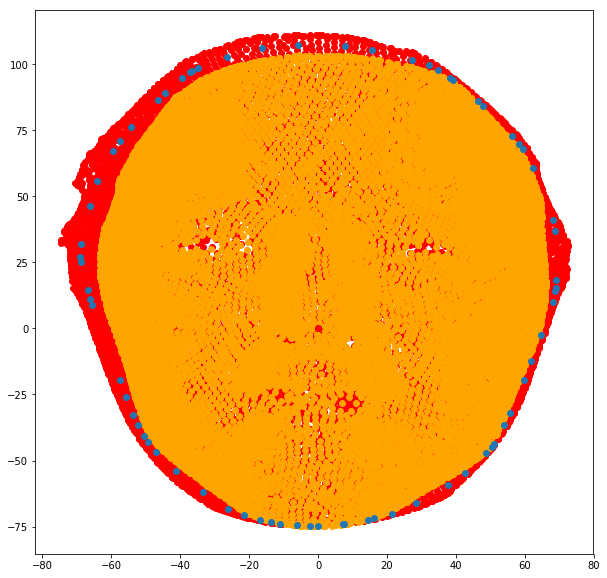

In [7]:
def hull72(points,nosex,nosey,nosez):
    from math import sin, cos
    newhull = [[nosex,nosey,nosez]]
    for theta in range(0,360,5):
        fx = 200*cos(theta)
        fy = 200*sin(theta)
        nearest_point = min(zip(points[:,0],points[:,1],points[:,2]), key=lambda p:(p[0]-fx)**2+(p[1]-fy)**2)
        newhull.append(nearest_point)
    return newhull

def get_hull(points):
    maxind = np.argmax(points[:,2])
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    hull = np.array(hull72(points, nosex,nosey,nosez))
    return hull

hull1 = get_hull(points1)
hull2 = get_hull(points2)
hull = (hull1 + hull2) /2


plt.figure(figsize=(10,10))
plt.scatter(points1[:,0], points1[:,1], color="red")
plt.scatter(points2[:,0], points2[:,1], color="orange")

plt.scatter(hull[:,0], hull[:,1])
maxind = np.argmax(points1[:,2])
nosex = points1[maxind,0]
nosey = points1[maxind,1]
nosez = points1[maxind,2]
plt.plot(nosex,nosey,"ro")
plt.show()



## Triangulation and Geodesic Patch Extraction

The main part of our algorithm is an iteration that takes the
best set of matches that have been established to date, and
grows the number of correspondences. For the first itera-
tion, we use the sparse set of correspondences established
as in the previous section, while for subsequent iterations
we determine the best set of n q matches from the full set of
n matches as described in Section 3.5.
In each iteration, given n q correspondences between N
faces, we perform a 2D Delaunay triangulation of the mean
x  y locations of the n q current best matches. This triangu-
lation is then used consistently across all faces. We then
pick a pair of parent/child nodes from the Minimum Span-
ning Tree P, F j and F k . For both faces in the pair, we extract a narrow surface patch S 1⁄4 f1⁄2x i ; y i ; z i  T ; i 1⁄4 1; . . . ; mg  F,
centered on a geodesic curve defined by each triangle
edge (see Fig. 4). For the sake of simplicity we call this a geo-
desic patch.
The (projected) length of the patch is the same as the
length of the edge. The “narrow” width is set with reference
to the scale of the original face mesh resolution. More specif-
ically, we set the width to be 5r where r is the average
mesh-edge length in the vicinity of the endpoint of the edge
(note that here the mesh-edges refer to the edges in the orig-
inal dataset, not the edges of the triangulation used for the
densification). This makes the extraction of the geodesic
patch scale invariant. The values of r for real 3D faces cap-
tured with the Minolta or the 3dMDface scanners typically
range from 1-3 mm.
Finally, we bring the patches S j ; S k into approximate
alignment using non-rigid registration [49], [50]. The pro-
cess is shown in Fig. 4.

In [8]:
def delaunay_triangulation(hull):
    points2D=np.vstack([hull[:,0],hull[:,1]]).T
    tri_hull = Delaunay(points2D)
    ipv.figure()
    mesh = ipv.plot_trisurf(hull[:,0], hull[:,1], hull[:,2], triangles=tri_hull.simplices, color='blue')
    ipv.scatter(hull[:,0], hull[:,1], hull[:,2], marker='sphere', color='red')
    ipv.show()
    return tri_hull

In [9]:
tri_hull = delaunay_triangulation(hull)



In [10]:
def get_patch(points, hull, x1, y1, z1):
    patch_width = 6
    def distance(x,y,z,x1,y1,z1,x2,y2,z2):
        a = (y2-y1)/(x2-x1)
        b = -1
        c = y2-x2*(y2-y1)/(x2-x1)
        return abs(a*x+b*y+c)/(a**2+b**2)**0.5

    patch = []
    nosex, nosey, nosez = hull[0]
    for x2,y2,z2 in points:
        if (y1-nosey)/(y2-nosey+0.0001)>0 and (x1-nosex)/(x2-nosex+0.0001)>0 \
        and distance(x2,y2,z2,x1,y1,z1,nosex,nosey,nosez)<patch_width:
            patch.append([x2,y2,z2])
    patch = np.array(patch)
    ipv.quickscatter(points[:,0],points[:,1],points[:,2], size=1, marker="sphere", color="red")
    ipv.scatter(patch[:,0],patch[:,1],patch[:,2], size=1, marker="sphere", color="blue")
    ipv.show()
    
    return patch

In [11]:
x1, y1, z1 = hull[1, :]
patch1 = get_patch(points1, hull, x1, y1, z1)

In [12]:
ipv.clear()
patch2 = get_patch(points2, hull, x1, y1, z1)

In [13]:
ipv.quickscatter(patch1[:,0], patch1[:,1], patch1[:,2], size=2, marker="sphere", color="red")
ipv.scatter(patch2[:,0],patch2[:,1],patch2[:,2], size=2, marker="sphere", color="blue")
ipv.show()

In [39]:
def points2meshgrid(points):
    [X, Y] = meshgrid(points[:,0], points[:,1])
    Z = interpolate.griddata((patch1[:, 0], patch1[:, 1]), patch1[:, 2], (X, Y), method='cubic')
    print(X.shape, Y.shape, Z.shape)
    ipv.figure()
    ipv.scatter(points[:,0],points[:,1],points[:,2])
#     ipv.scatter(X.reshape(-1), Y.reshape(-1), Z.reshape(-1), color="orange")
    ipv.show()
    
points2meshgrid(patch1)

(308, 308) (308, 308) (308, 308)


In [30]:
def surface_curvature(X,Y,Z):

    (lr,lb)=X.shape

    print (lr)
    print (lb)
    #First Derivatives
    Xv,Xu=np.gradient(X)
    Yv,Yu=np.gradient(Y)
    Zv,Zu=np.gradient(Z)

    #Second Derivatives
    Xuv,Xuu=np.gradient(Xu)
    Yuv,Yuu=np.gradient(Yu)
    Zuv,Zuu=np.gradient(Zu)   

    Xvv,Xuv=np.gradient(Xv)
    Yvv,Yuv=np.gradient(Yv)
    Zvv,Zuv=np.gradient(Zv) 

    #2D to 1D conversion 
    #Reshape to 1D vectors
    Xu=np.reshape(Xu,lr*lb)
    Yu=np.reshape(Yu,lr*lb)
    Zu=np.reshape(Zu,lr*lb)
    Xv=np.reshape(Xv,lr*lb)
    Yv=np.reshape(Yv,lr*lb)
    Zv=np.reshape(Zv,lr*lb)
    Xuu=np.reshape(Xuu,lr*lb)
    Yuu=np.reshape(Yuu,lr*lb)
    Zuu=np.reshape(Zuu,lr*lb)
    Xuv=np.reshape(Xuv,lr*lb)
    Yuv=np.reshape(Yuv,lr*lb)
    Zuv=np.reshape(Zuv,lr*lb)
    Xvv=np.reshape(Xvv,lr*lb)
    Yvv=np.reshape(Yvv,lr*lb)
    Zvv=np.reshape(Zvv,lr*lb)

    Xu=np.c_[Xu, Yu, Zu]
    Xv=np.c_[Xv, Yv, Zv]
    Xuu=np.c_[Xuu, Yuu, Zuu]
    Xuv=np.c_[Xuv, Yuv, Zuv]
    Xvv=np.c_[Xvv, Yvv, Zvv]

    #% First fundamental Coeffecients of the surface (E,F,G)
    E=np.einsum('ij,ij->i', Xu, Xu) 
    F=np.einsum('ij,ij->i', Xu, Xv) 
    G=np.einsum('ij,ij->i', Xv, Xv) 

    m=np.cross(Xu,Xv,axisa=1, axisb=1) 
    p=np.sqrt(np.einsum('ij,ij->i', m, m)) 
    n=m/np.c_[p,p,p]
    # n is the normal
    #% Second fundamental Coeffecients of the surface (L,M,N), (e,f,g)
    L= np.einsum('ij,ij->i', Xuu, n) #e
    M= np.einsum('ij,ij->i', Xuv, n) #f
    N= np.einsum('ij,ij->i', Xvv, n) #g

    # Alternative formula for gaussian curvature in wiki 
    # K = det(second fundamental) / det(first fundamental)
    #% Gaussian Curvature
    K=(L*N-M**2)/(E*G-L**2)
    K=np.reshape(K,lr*lb)
    #wiki trace of (second fundamental)(first fundamental inverse)
    #% Mean Curvature
    H = (E*N + G*L - 2*F*M)/((E*G - F**2))
    print (H.shape)
    H = np.reshape(H,lr*lb)

    #% Principle Curvatures
    Pmax = H + np.sqrt(H**2 - K)
    Pmin = H - np.sqrt(H**2 - K)
    #[Pmax, Pmin]
    return [Pmax, Pmin, G, H]


def fun(x,y):
    return x**2+y**2

In [31]:
x1 = scipy.linspace(-1,1,20)
y1 = scipy.linspace(-1,1,20)
[x1,y1]=scipy.meshgrid(x1,y1)
z1 = (x1**3 +y1**2 +x1*y1)

z1.shape


(20, 20)

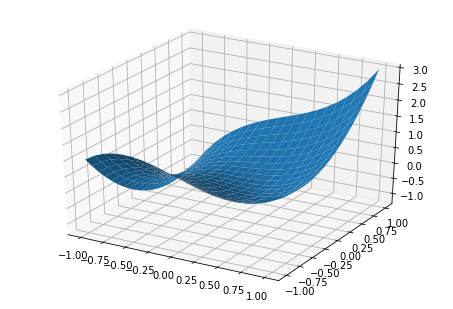

In [32]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x1,y1,z1)
plt.show()

In [33]:
x1, y1, z1 = patch1[:, 0], patch1[:, 1], patch1[:, 2]

In [34]:
[x, y] = scipy.meshgrid(x1, y1)

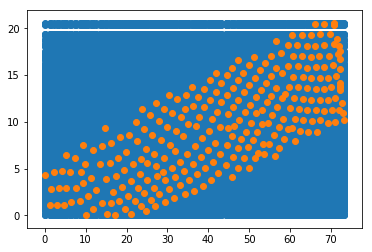

In [35]:
plt.scatter(x, y);
plt.scatter(x1, y1)

In [265]:

[len(x), len(y)]

[308, 308]

In [36]:
int_values = scipy.interpolate.griddata((patch1[:, 0], patch1[:, 1]), patch1[:, 2], (x, y), method='cubic')

In [37]:
int_values.shape

(278, 278)

/home/tsukuyomi/Envs/MLenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


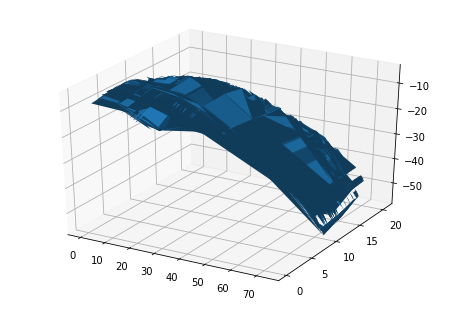

In [38]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x,y,int_values)
plt.show()

In [39]:
x.shape, y.shape, z.shape

NameError: name 'z' is not defined

In [40]:
ipv.figure()
ipv.plot_surface(x, int_values, y)
ipv.show()

In [41]:
surface_curvature(x,y,int_values)

278
278
(77284,)


/home/tsukuyomi/Envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/home/tsukuyomi/Envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in sqrt


[array([       nan,        nan,        nan, ..., 0.06345684,        nan,
               nan]),
 array([        nan,         nan,         nan, ..., -0.10239644,
                nan,         nan]),
 array([0.00091903, 0.00073944, 0.00076057, ..., 0.30816705, 0.30268446,
               nan]),
 array([       nan,        nan,        nan, ..., -0.0194698,        nan,
               nan])]

In [180]:
surface_curvature(x1, y1, z1);

20
20
(400,)


/home/tsukuyomi/Envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/home/tsukuyomi/Envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in sqrt


In [163]:
x, y, z = patch1[:, 0], patch1[:, 1], patch1[:, 2]

In [166]:
surface_curvature(x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1))

> <ipython-input-162-650247145637>(7)surface_curvature()
-> Xv,Xu=np.gradient(X)
(Pdb) c


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.